In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import os, cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [20]:
image_folder = "data/train/images"
annotation_folder = "data/train/labels"

In [3]:
sample_image = "000480.jpg"
image_path = os.path.join(image_folder, sample_image)
annotation_path = os.path.join(annotation_folder, sample_image.replace(".jpg", ".xml"))

In [4]:
tree = ET.parse(annotation_path)
root = tree.getroot()

In [5]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

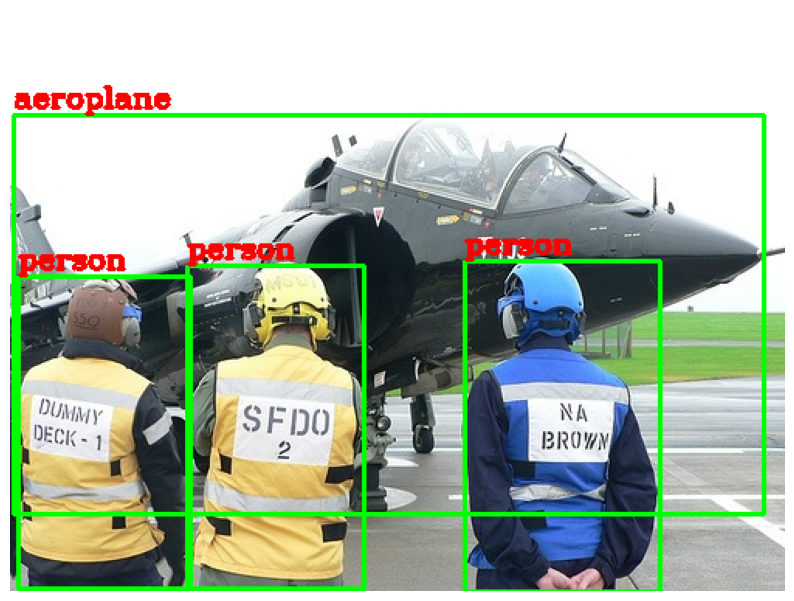

In [6]:
for obj in root.findall("object"):
    name = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    # draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    cv2.putText(img, name, (xmin, ymin - 5), 
               cv2.FONT_HERSHEY_COMPLEX, 0.6, (255, 0, 0), 2)

#visualize
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

In [7]:
class YOLOdataset(Dataset):

    def __init__(self, image_dir, annot_dir, S=7, B=2, C=20, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.S = S # grid size (7x7)
        self.B = B # number of bounding boxes per grid
        self.C = C # number of classes (20 for VOC)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, img_filename)
        annotation_path = os.path.join(self.annot_dir, img_filename.replace(".jpg", ".xml"))

        # load image
        image = Image.open(image_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(annotation_path, image.size)

        # Convert to YOLO grid format
        target = self.encode_target(boxes, labels, self.S, self.B, self.C)

        if self.transform:
            image = self.transform(image)

        return image, target


    # this function reads the annotation xml file and fetches the bounding boxes and labels from it.
    # in simple words it finds where the object is and what is the object.
    def parse_voc_xml(self, xml_path, image_size):
        boxes = []
        labels = []
        tree = ET.parse(xml_path)
        root = tree.getroot()
        w, h = image_size

        for obj in root.findall("object"):
            label = obj.find("name").text
            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            ymin = float(xml_box.find("ymin").text)
            xmax = float(xml_box.find("xmax").text)
            ymax = float(xml_box.find("ymax").text)

            # Normalize to [0,1] so that model does not depend on the image size
            # below are the same x, y, w, h but in normalize form
            x_center = ((xmin + xmax) / 2) / w # box's center x-coordinate
            y_center = ((ymin + ymax) / 2) / h # box's center y-coordinate
            box_w = (xmax - xmin) / w          # box's width
            box_h = (ymax - ymin) / h          # box's height

            boxes.append([x_center, y_center, box_w, box_h])
            labels.append(self.class_to_index(label))
            
        return boxes, labels

        # above fucntion example
        # boxes = [
        #   [0.45, 0.62, 0.3, 0.25],   # dog
        #   [0.73, 0.55, 0.12, 0.20]   # person
        # ]
        # labels = [12, 3]  # (dog = 12, person = 3)


    # boxes: normalized bounding boxes [x_center, y_center, width, height]
    # labels: corresponding class indices (jaise 0=person, 1=dog)
    # S: grid ka size (YOLO v1 me 7x7 hota hai)
    # B: har grid cell me kitne boxes predict karne hain (YOLO v1 me 2)
    # C: total number of classes

    # below function work is to convert the image annotations into (S, S, C + 5B) tensor.
    # exactly the same shape as model output's shape

    def encode_target(self, boxes, labels, S, B, C):
        target = torch.zeros((S, S, C + 5 * B))  # creating the empty tensor For YOLOv1 (S=7, B=2, C=20):→ Shape = (7, 7, 30)

        for box, label in zip(boxes, labels):
            x, y, w, h = box

            # Example:
            # Agar x=0.45, y=0.62 aur S=7
            # → grid_x = int(0.457) = 3
            # → grid_y = int(0.627) = 4
            # Matlab object ka center row 4, column 3 wale grid me hai.

            # Find which grid cell me object aata hai
            grid_x = int(x * S)
            grid_y = int(y * S)

            # Find relative coordinates inside that grid
            # Agar x=0.45 aur S=7
            # x * S = 3.15
            # grid_x = 3
            # to x_cell = 0.15
            # matlab object cell ke andar thoda right me hai.
                
            x_cell = x * S - grid_x
            y_cell = y * S - grid_y

            # Fill one of the bounding boxes (say first B)
            target[grid_y, grid_x, 0:5] = torch.tensor([x_cell, y_cell, w, h, 1])
            # har grid cell ke liye hum 5 values store karte hain:
            # x_cell, y_cell → center offset inside cell
            # w, h → normalized width & height
            # 1 → confidence (object exists)
            # sirf ek bounding box ko fill kar rahe hain (maan lo pehla B=2 me se first).

            
            target[grid_y, grid_x, C] = 1  # mark that object exists
            # ye ek indicator flag hai jisse batate hain ki is grid cell me object present hai.
            
            target[grid_y, grid_x, 5:] = 0
            target[grid_y, grid_x, label] = 1  # one-hot for class
            # har grid cell ke liye class probabilities bhi store karte hain.
            # to agar dog ka class index 12 hai, to class vector me sirf 12th index pe 1 set hoga.
            
        return target
        # maan lo ek image me ek object hai:
        # box = [0.45, 0.62, 0.2, 0.15]  # normalized
        # label = 3                      # class = 'car'
        # aur S=7, B=2, C=20
        # to final target[4, 3] cell kuch aisa dikhega:
        # [0.15, 0.34, 0.2, 0.15, 1, 0,0,0,1,0,0,0,0,0,...]
        # → first 5 = box params
        # → last 20 = one-hot class vector
    

    def class_to_index(self, label):
        classes = [
            "aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"
        ]
        return classes.index(label)

In [8]:
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
])

In [9]:
train_dataset = YOLOdataset(
    image_dir="data/train/Images",
    annot_dir="data/train/labels",
    transform=transform
)

test_dataset = YOLOdataset(
    image_dir="data/test/Images",
    annot_dir="data/test/labels",
    transform=transform
)

image, target = train_dataset[0]
print(image.shape)  # [3, 448, 448]
print(target.shape) # [7, 7, 30]

torch.Size([3, 448, 448])
torch.Size([7, 7, 30])


In [10]:
train_loader = DataLoader(train_dataset,batch_size=2,shuffle=True,num_workers=0)

test_loader = DataLoader(test_dataset,batch_size=2,shuffle=False,num_workers=0)

In [11]:
for imgs, targets in train_loader:
    print("Batch image shape:", imgs.shape)    # [batch_size, 3, 448, 448]
    print("Batch target shape:", targets.shape) # [batch_size, 7, 7, 30]
    break

Batch image shape: torch.Size([2, 3, 448, 448])
Batch target shape: torch.Size([2, 7, 7, 30])


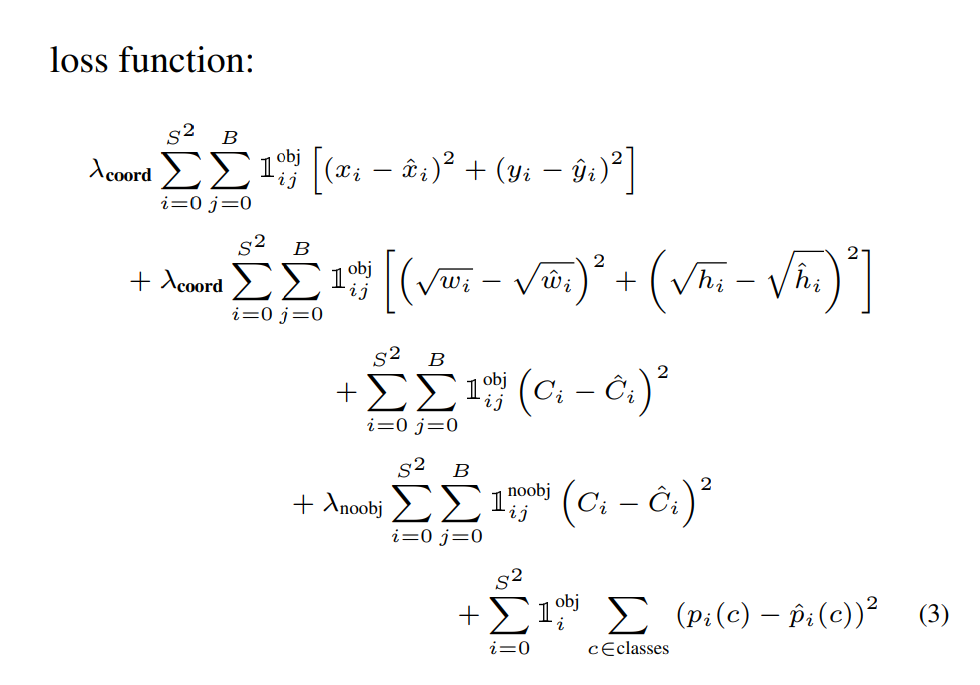

In [12]:
from IPython.display import Image as IPyImage, display

display(IPyImage(filename='loss_func.png'))

In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20, λ_coord=5, λ_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = λ_coord
        self.lambda_noobj = λ_noobj

    def forward(self, predictions, target):
        # Reshape to [batch_size, S, S, (C + B*5)]
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # --- 1️⃣ Identify cells containing objects ---
        obj_mask = target[..., self.C + 4].unsqueeze(-1)  # 1 if object present

        # --- 2️⃣ Localization loss ---
        box_pred = predictions[..., self.C:self.C + 5]
        box_target = target[..., self.C:self.C + 5]

        # Only for cells containing object
        box_pred_xy = obj_mask * box_pred[..., :2]
        box_target_xy = obj_mask * box_target[..., :2]

        box_pred_wh = obj_mask * torch.sign(box_pred[..., 2:4]) * torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))
        box_target_wh = obj_mask * torch.sqrt(box_target[..., 2:4])

        coord_loss = self.mse(box_pred_xy, box_target_xy) + self.mse(box_pred_wh, box_target_wh)
        coord_loss = self.lambda_coord * coord_loss

        # --- 3️⃣ Object confidence loss ---
        conf_pred = predictions[..., self.C + 4]
        conf_target = target[..., self.C + 4]

        obj_conf_loss = self.mse(obj_mask.squeeze(-1) * conf_pred, obj_mask.squeeze(-1) * conf_target)

        # --- 4️⃣ No object confidence loss ---
        noobj_mask = 1 - obj_mask
        noobj_conf_loss = self.mse(noobj_mask.squeeze(-1) * conf_pred, noobj_mask.squeeze(-1) * conf_target)
        noobj_conf_loss = self.lambda_noobj * noobj_conf_loss

        # --- 5️⃣ Classification loss ---
        class_pred = predictions[..., :self.C]
        class_target = target[..., :self.C]

        class_loss = self.mse(obj_mask * class_pred, obj_mask * class_target)

        # --- Final total loss ---
        total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss
        return total_loss

In [14]:
loss_fn = YoloLoss(S=7, B=2, C=20)

In [1]:
class YOLO(nn.Module):
    def __init__(self, B, C):
        super().__init__()

        self.B = B
        self.C = C
        self.dropout = nn.Dropout(0.5)

        
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=7, stride=2, padding=3) #1
        self.leaky1 = nn.LeakyReLU(0.1)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0) #2

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1) #3
        self.leaky2 = nn.LeakyReLU(0.1)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #4

        self.conv_3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0) #5
        self.leaky3 = nn.LeakyReLU(0.1)

        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) #6
        self.leaky4 = nn.LeakyReLU(0.1)

        self.conv_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=0) #7
        self.leaky5 = nn.LeakyReLU(0.1)

        self.conv_6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1) #8
        self.leaky6 = nn.LeakyReLU(0.1)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #9


        # 10–17
        self.conv_7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #10
        self.leaky7 = nn.LeakyReLU(0.1)

        self.conv_8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #11
        self.leaky8 = nn.LeakyReLU(0.1)

        self.conv_9 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #12
        self.leaky9 = nn.LeakyReLU(0.1)

        self.conv_10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #13
        self.leaky10 = nn.LeakyReLU(0.1)

        self.conv_11 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #14
        self.leaky11 = nn.LeakyReLU(0.1)

        self.conv_12 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #15
        self.leaky12 = nn.LeakyReLU(0.1)

        self.conv_13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #16
        self.leaky13 = nn.LeakyReLU(0.1)

        self.conv_14 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #17
        self.leaky14 = nn.LeakyReLU(0.1)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)



        self.conv_15 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0) #18
        self.leaky15 = nn.LeakyReLU(0.1)

        self.conv_16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #19
        self.leaky16 = nn.LeakyReLU(0.1)

        self.conv_17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0) #20
        self.leaky17 = nn.LeakyReLU(0.1)

        self.conv_18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #21
        self.leaky18 = nn.LeakyReLU(0.1)

        self.conv_19 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #22
        self.leaky19 = nn.LeakyReLU(0.1)

        self.conv_20 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1) #23
        self.leaky20 = nn.LeakyReLU(0.1)

        self.conv_21 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #24
        self.leaky21 = nn.LeakyReLU(0.1)



        # self.fc1 = nn.Linear(in_features=7*7*1024, out_features=4096)
        # self.leaky22 = nn.LeakyReLU(0.1)
        # self.fc2 = nn.Linear(4096, 7*7*(self.B*5 + self.C))

        self.fc1 = nn.Linear(in_features=self.S*self.S*1024, out_features=4096)
        self.leaky22 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(4096, self.S*self.S*(self.B*5 + self.C))

        # B = 2 (bounding boxes per grid cell)
        # C = 20 (for Pascal VOC 20 classes)


    def forward(self, x):

        out1 = self.leaky1(self.conv_1(x))
        out2 = self.max_pool_1(out1)

        out3  = self.leaky2(self.conv_2(out2))
        out4 = self.max_pool_2(out3)

        out4 = self.leaky3(self.conv_3(out4))
        out5 = self.leaky4(self.conv_4(out4))
        out6 = self.leaky5(self.conv_5(out5))
        out7 = self.leaky6(self.conv_6(out6))
        out8 = self.max_pool_3(out7)
        out9 = self.leaky7(self.conv_7(out8))
        out10 = self.leaky8(self.conv_8(out9))
        out11 = self.leaky9(self.conv_9(out10))
        out12 = self.leaky10(self.conv_10(out11))
        out13 = self.leaky11(self.conv_11(out12))
        out14 = self.leaky12(self.conv_12(out13))
        out15 = self.leaky13(self.conv_13(out14))
        out16 = self.leaky14(self.conv_14(out15))
        out17 = self.max_pool_4(out16)
        out18 = self.leaky15(self.conv_15(out17))
        out19 = self.leaky16(self.conv_16(out18))
        out20 = self.leaky17(self.conv_17(out19))
        out21 = self.leaky18(self.conv_18(out20))
        out22 = self.leaky19(self.conv_19(out21))
        out23 = self.leaky20(self.conv_20(out22))
        out24 = self.leaky21(self.conv_21(out23))

        out25 = out24.view(out24.size(0), -1)
        out26 = self.leaky22(self.fc1(out25))
        out27 = self.dropout(out26)
        out28 = self.fc2(out27)


        return out28

NameError: name 'nn' is not defined

In [16]:
device = "cuda"  if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
import gc
# device = "cpu"
gc.collect()
torch.cuda.empty_cache()

model = YOLO(B=2, C=20)
model.to(device)

YOLO(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (leaky1): LeakyReLU(negative_slope=0.1)
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky2): LeakyReLU(negative_slope=0.1)
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
  (leaky3): LeakyReLU(negative_slope=0.1)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky4): LeakyReLU(negative_slope=0.1)
  (conv_5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (leaky5): LeakyReLU(negative_slope=0.1)
  (conv_6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky6): LeakyReLU(negative_slope=0.1)
  (max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [18]:
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

# i know that in original YOLOv1 they have used the SGD with momentum
# but we will use the Adam here for the faster convergence

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os

# -----------------------------
# CONFIG
# -----------------------------

EPOCHS = 5
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
CHECKPOINT_DIR = "training_info/checkpoints"
PREDICTIONS_DIR = "training_info/predictions"
LOG_DIR = "training_info/logs"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
writer = SummaryWriter(LOG_DIR)

# -----------------------------
# TRAINING LOOP
# -----------------------------
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, total = len(train_loader), desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for imgs, tragets in loop:
        imgs, targets = imgs.to(DEVICE), tragets.to(DEVICE)

        # forward
        preds = model(imgs)
        loss = loss_fn(preds, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_loss, epoch)
    scheduler.step()

    print(f"✅ Epoch [{epoch+1}/{EPOCHS}] | Avg Loss: {avg_loss:.4f}")


    # -----------------------------
    # 🔹 Save Checkpoint
    # -----------------------------
    ckpt_path = os.path.join(CHECKPOINT_DIR, f"yolov1_epoch{epoch+1}.pth")
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss
    }, ckpt_path)

    # -----------------------------
    # 🔹 Save Predictions
    # -----------------------------
    model.eval()
    with torch.no_grad():
        sample_imgs, sample_targets = next(iter(train_loader))
        sample_imgs = sample_imgs.to(DEVICE)
        pred_boxes = model(sample_imgs)

        # Convert prediction tensor to (x, y, w, h, conf, class) — adjust as per your postprocessing
        pred_path = os.path.join(PREDICTIONS_DIR, f"pred_epoch{epoch+1}.pt")
        torch.save(pred_boxes.cpu(), pred_path)


writer.close()
print("🎯 Training complete!")

Epoch [1/5]:   1%|▍                                                 | 99/11068 [03:50<7:06:03,  2.33s/it, loss=5.3e+10]


KeyboardInterrupt: 